In [1]:
import sys
sys.path.append('../')

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from ATARI.ModelData.particle_pair import Particle_Pair
from ATARI.ModelData.particle import Particle, Neutron
from ATARI import TAZ 

In [2]:
# %matplotlib widget

In [3]:
Ta181 = Particle(Z=73, A=181, I=3.5, mass=180.94803, name='Ta181')
Ta_pair = Particle_Pair(isotope = "Ta181",
                        resonance_ladder = pd.DataFrame(),
                        formalism = "XCT",
                        energy_range = [200,1000],
                        ac = 0.8127,
                        target=Ta181,
                        projectile=Neutron,
                        l_max = 1
)

# print quant number map up to l_max
Ta_pair.map_quantum_numbers(print_out=True)

# J = 3, <D> = 9.0030 eV, <gn2> = 452.56615 meV, <gg2> = 32.0 meV
# J = 4, <D> = 8.3031 eV, <gn2> = 332.24347 meV, <gg2> = 32.0 meV

# add spin group information for both s-wave resonances
Ta_pair.add_spin_group(Jpi='3.0',
                       J_ID=1,
                       D=9.0030,
                       gn2_avg=452.56615,
                       gn2_dof=1,
                       gg2_avg=32.0,
                       gg2_dof=1000)

Ta_pair.add_spin_group(Jpi='4.0',
                       J_ID=2,
                       D=8.3031,
                       gn2_avg=332.24347,
                       gn2_dof=1,
                       gg2_avg=32.0,
                       gg2_dof=1000)

print()
print("Interrogate spin group attribute:")
print(Ta_pair.spin_groups[3.0])


print()
print("Resonance ladder sampled from resonance statistics:")
print(Ta_pair.sample_resonance_ladder())

Spin group data for all parity
(Jpi, #Chs, l-waves)
(-5.0, 1, [1])
(-4.0, 2, [1, 1])
(-3.0, 2, [1, 1])
(-2.0, 1, [1])
(3.0, 1, [0])
(4.0, 1, [0])

Interrogate spin group attribute:
{'Jpi': 3.0, 'J_ID': 1, '<D>': 9.003, '<gn2>': 452.56615, 'n_dof': 1, '<gg2>': 32.0, 'g_dof': 1000, 'quantiles': {'D01': 1.0184333135415622, 'D99': 21.80043460630884, 'gn01': 0.0710926470659408, 'gn99': 3002.729610372257, 'gg01': 28.765198301747624, 'gg99': 35.42300781927096, 'gt01': 28.836290948813566, 'gt99': 3038.152618191528}, 'chs': 1, 'Ls': [0]}

Resonance ladder sampled from resonance statistics:
              E         Gg         Gn1  J_ID        gg2          gn2  Jpi    L
0    202.954933 -61.944644 -107.280228   1.0 -30.972322 -2120.712354  3.0  0.0
1    213.423037 -64.832970  -36.099899   1.0 -32.416485  -695.900623  3.0  0.0
2    229.002523 -65.824827    0.095873   1.0 -32.912413     1.784183  3.0  0.0
3    248.632888  61.900245   -8.077407   1.0  30.950122  -144.262863  3.0  0.0
4    262.888920  

In [4]:
# Ta_pair.resonance_ladder

### Translate from Particle_Pair to Reaction
TAZ has a `Reaction` class to hold data similar to `Particle_Pair`. However, `Reaction` holds some extra information to that of `Particle_Pair` for resonance statistics applications. `ATARI_interface` translates between ATARI and TAZ objects.

In [5]:
reaction, resonances, Spingroup_IDs = TAZ.ATARI_interface.ATARI_to_TAZ(Ta_pair, false_dens=0.0)

print('Target Particle:')
print(repr(reaction.targ))
print()
print('Reaction Parameters')
print(reaction)

Target Particle:
Particle       = Ta181
Atomic Number  = 0
Atomic Mass    = 181
Nuclear Spin   = 3.5
Mass           = 180.9480300 (amu)
Nuclear Radius = 0.6957683 (√b)


Reaction Parameters
Target Particle      = Ta181
Projectile Particle  = neutron?
Channel Radius       = 0.8127000 (√b)
Energy Bounds        = 2.000e+02 < E < 1.000e+03 (eV)
False Level Density  = 0.0000000 (1/eV)

                             3+           4+
Level Densities        0.111074     0.120437
Brody Parameters       1.000000     1.000000
Mean Neutron Width   452.566150   332.243470
Neutron Width DOF      1.000000     1.000000
Mean Gamma Width      32.000000    32.000000
Gamma Width DOF     1000.000000  1000.000000
Missing Fraction       0.000000     0.000000


### Porter-Thomas Probabilities

`PTBayes` calculates resonance width probabilities using Porter-Thomas distribution. This is almost always the first step in any TAZ algorithm.

In [6]:
PT_probs, PT_log_likelihood = TAZ.PTBayes(resonances, reaction)
print('Porter-Thomas Posterior')
print(PT_probs)

Porter-Thomas Posterior
[[0.64863749 0.35136251 0.        ]
 [0.47466536 0.52533464 0.        ]
 [0.44467646 0.55532354 0.        ]
 [0.58236205 0.41763795 0.        ]
 [0.51074201 0.48925799 0.        ]
 [0.46019337 0.53980663 0.        ]
 [0.50004745 0.49995255 0.        ]
 [0.44158103 0.55841897 0.        ]
 [0.49570164 0.50429836 0.        ]
 [0.44738608 0.55261392 0.        ]
 [0.45568139 0.54431861 0.        ]
 [0.44568781 0.55431219 0.        ]
 [0.47533749 0.52466251 0.        ]
 [0.44925264 0.55074736 0.        ]
 [0.44208074 0.55791926 0.        ]
 [0.4432924  0.5567076  0.        ]
 [0.49935165 0.50064835 0.        ]
 [0.48715368 0.51284632 0.        ]
 [0.5145446  0.4854554  0.        ]
 [0.44341118 0.55658882 0.        ]
 [0.44141905 0.55858095 0.        ]
 [0.5048882  0.4951118  0.        ]
 [0.46571231 0.53428769 0.        ]
 [0.53744996 0.46255004 0.        ]
 [0.44194021 0.55805979 0.        ]
 [0.45292226 0.54707774 0.        ]
 [0.44569477 0.55430523 0.        ]
 [0.

### Preparing RunMaster
`RunMaster` is a wrapper around `Encore` that performs pre-and-post processing for each algorithm in `Encore`. Creating a `RunMaster` object will precalculate level-spacings and prepare the __cumulative probabilities__ which will be used in many of the `Encore` algorithms. Note that the `WigMaxLikelihoods` algorithm is a class method of `RunMaster` (and `Encore`) as it does not need to calculate __cumulative probabilities__.

`RunMaster` also performs __merging__ if specified which is an approximation that allows one to run `Encore` algorithms with less effective spingroups multiple times. This feature is only useful when 4 or more spingroups are provided. __Merging__ is only supported by `WigBayes` at this time.

In [7]:
distributions = reaction.distributions('Wigner')
runMaster = TAZ.RunMaster(Ta_pair.resonance_ladder['E'],
                          Ta_pair.energy_range,
                          level_spacing_dists=distributions,
                          false_dens=reaction.false_dens,
                          prior=PT_probs,
                          log_likelihood_prior=PT_log_likelihood)

### WigBayes
The WigBayes algorithm is run below. The `analysis` module holds various functions for testing performance.

Wigner Posterior Probabilities:
[[ 6.41763574e-01  3.58297252e-01 -6.08262493e-05]
 [ 4.42860975e-01  5.57199852e-01 -6.08262493e-05]
 [ 4.33519825e-01  5.66541001e-01 -6.08262493e-05]
 [ 5.64372568e-01  4.35688258e-01 -6.08262493e-05]
 [ 5.07211251e-01  4.92849575e-01 -6.08262493e-05]
 [ 4.22068399e-01  5.77992428e-01 -6.08262493e-05]]
...

Confusion Matrix:
    A   B  F
A  30  23  0
B  61  75  0
F   0   0  0

Brier Score:
PT only score =  50.44%
Wigner + PT score =  50.80%


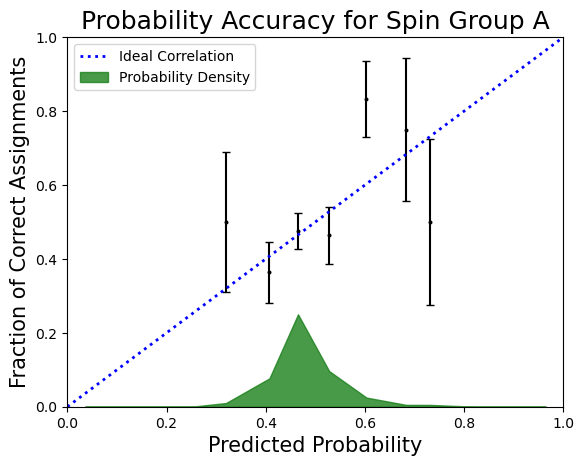

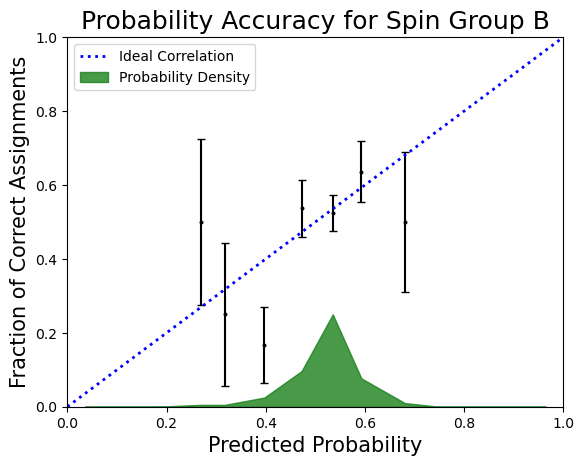

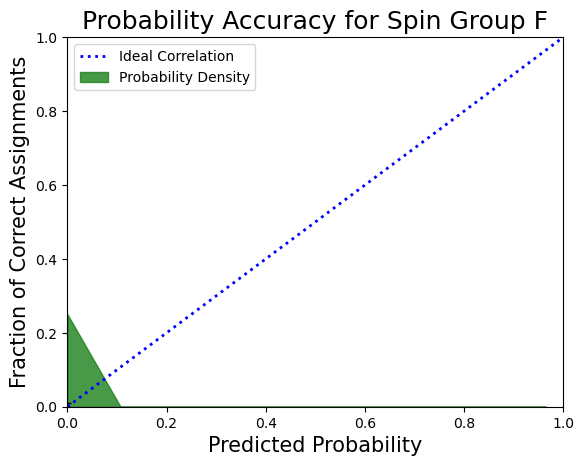

In [8]:
posterior = runMaster.WigBayes()
print('Wigner Posterior Probabilities:')
print(posterior[:6,:])
print('...')
print()
TAZ.analysis.ConfusionMatrix(posterior, Spingroup_IDs, ['A', 'B', 'F'])
print()
print('Brier Score:')
TAZ.analysis.PrintScore(PT_probs, Spingroup_IDs, 'PT only', metric='Brier score')
TAZ.analysis.PrintScore(posterior, Spingroup_IDs, 'Wigner + PT', metric='Brier score')

TAZ.analysis.ProbCorrPlot(posterior, Spingroup_IDs, ['A', 'B', 'F'], fig_num=100)

### WigSample
Samples spingroups with probability weighted by the ladder likelihood, provided the spingroup assignments. Any number of samples can be chosen.

In [9]:
num_trials = 200 # number of samples
Samples = runMaster.WigSample(num_trials)

Spingroup samples should roughly follow Wigner distribution. Here, we can test that rule.

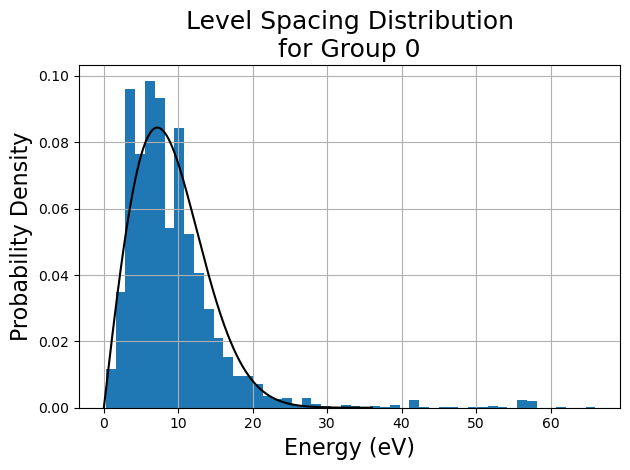

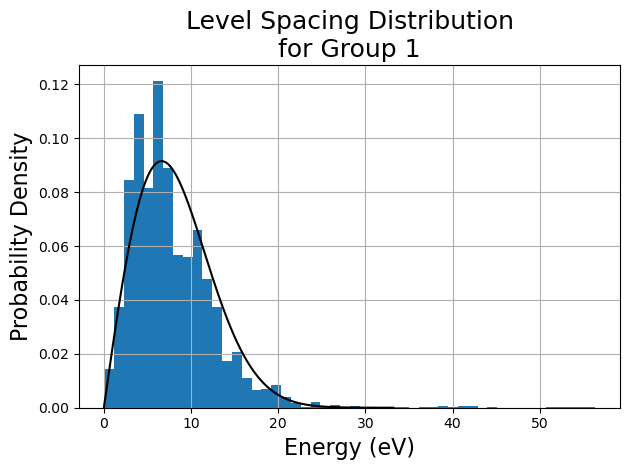

In [10]:
for g in range(2):
    lvl_spacing = np.zeros((0,))
    for trial in range(num_trials):
        E = resonances.E[Samples[:,trial] == g]
        lvl_spacing = np.concatenate((lvl_spacing, np.diff(E)))
    lvl_spacing = np.sort(lvl_spacing)

    xMax = 4 / reaction.lvl_dens_all[g]
    L_fit = 1000
    X = np.linspace(0.0, xMax, L_fit)
    PDF = reaction.fit('level spacing', g)(X)

    plt.figure(g+30)
    plt.clf()
    plt.hist(lvl_spacing, 50, density=True)
    plt.plot(X, PDF, '-k')
    plt.grid()
    plt.title(f'Level Spacing Distribution\nfor Group {g}', fontsize=18)
    plt.xlabel('Energy (eV)', fontsize=16)
    plt.ylabel('Probability Density', fontsize=16)
    plt.tight_layout()
    plt.show()

### WigMaxLikelihoods
This class method returns the most likely spingroup assignments for the provided resonance ladder.

In [11]:
best_ladders, best_log_likelihoods = TAZ.RunMaster.WigMaxLikelihoods(
                          Ta_pair.resonance_ladder['E'],
                          Ta_pair.energy_range,
                          level_spacing_dists=distributions,
                          false_dens=reaction.false_dens,
                          num_best=5,
                          prior=PT_probs)

print('Best Spingroup Ladders:')
print(best_ladders)

Best Spingroup Ladders:
[array([0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
       0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1,
       0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1,
       0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1,
       0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0,
       0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1], dtype=int8), array([0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
       0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1,
       0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,